# Tutorial 04: Deep Dive Into QDC Data (Special Guests: TDC & Scaler Datasets!)

Last time we did look into how to access the contents of a raw data file and how to process the **entries** in a **tree** across **branches** so we can read all the data and measurement values that belong to a single event (entry) together. This time, we will 

- look into how the QDC actually performs its measurement
- learn about something called "pedestal" and try to figure out how to handle that kind of thing
- look into the TDC and Scalar related branches and try to figure out how we can combine this information with the data from the QDC
- answer any questions you may have had

There is a lot to do, let's get started!



## How does a QDC actually work & who put something on a pedestal???

So far we have established, that 
- A QDC is a "Charge To Digital" converter
- It measures charge by integrating electrical current over time, i.e.

  $$I(t) = \frac{dQ}{dt} \quad \Longrightarrow \quad Q = \int_{t_{START}}^{t_{END}} I(t)\;dt $$
  
- In order to get a "number" as the result of the measurement, the integral has to be "definite" i.e., we have to integrate between boundaries ($t_{START}$ and $t_{END}$ in the formula above). This means that our integration is measuring the area under the curve $I(t)$ between the points in time $ \left[t_{START},t_{END}\right] $. 

![](https://codimd.web.cern.ch/uploads/upload_888d12857db141a4a10c0783e921bd8e.png)

  It is important to chose the integration interval not too large (otherwise we will capture a lot of contributions of noise and will artifically increase our value for Q) and not too small (otherwise we will not measure the area under the curve of the whole signal). Also, we have to check that the signal really arrives between $t_{START}$ and $t_{END}$. **The whole process of ensuring this things is called "timing-in" for a signal**, you will find descriptions how we did things in the lab book!


### Team Mavericks had an excellent Question:

```
The time period over which the QDC integrates the current was apparently very important.  Where can we find that info in the log book?
```

**ANSWER**: You can find the integraton time in the log book, but it is a bit hidden. The QDC takes $t_{START}$ and $t_{END}$ from the "edges" of the trigger signal. I.e., the length of the interval is the length of the trigger interval. If a trigger signal is used like this, we call it a **GATE** signal.

![](https://codimd.web.cern.ch/uploads/upload_480a8cb2c38def8fa972e4225dc29661.png)

- Using this idea, one can easily derive numerical methods to calculate the area under the curve, for example the [Trapezoid method](https://en.wikipedia.org/wiki/Trapezoidal_rule) method:

$$\; Q = \int_{t_{START}}^{t_{END}}I(t)\,dt \; \approx \; \frac{t_{END} - t_{START}}{2\cdot N}\; \left( I(t_{START}) \; + \; I(t_{END}) \; + \; \sum_{i=1}^{N-2} 2\,I(t_i) \right) \quad \text{with} \; t_i  \; \text{being the} \; N - 2 \; \text{equally spaced points between} \; t_{START} \; \text{and} \; t_{END} $$

- This is for example how the Sakura Particles team plan to measure the deposited energy with their updated electronics 

- The QDC that we are using is a `CAEN v792AC` and it works slightly differently. It charges a capacitor with the analog signal $I(t)$ while the "Gate" is open (i.e., between $t_{START}$ and $t_{END}$ to "integrate" the signal "analogly". Then, once the "Gate" is closed (i.e., after we pass $t_{END}$), we measure the charge collected in the capacitor using an `Analog-To-Digital Converter` (ADC) which is essentially a counter. The higher the counting value· the more charge - this works pretty similar to the Arduino ADC that you have used to measure voltages!


![](https://codimd.web.cern.ch/uploads/upload_4b7f8ff68449e994cd4db1578fb31db8.png)

If you look closely, you will see that we are not only integrating the signal $I(t)$ but also have something there that is called $I_{PED}$. This is the so called **pedestal current** and it helps us avoid two issues:

1) if $V_{out}$ is very small (let's say a QDC count of `1`), then it can happen that the count is recorded at the `ADC` as `0` or `2`, due to rounding. This is unavoidable if you measure something by counting, the name of this problem is **Quantization Error**. If you measure such a small quantity, the relative error that you make is huge:

$$ Error = \left| \frac{\text{Count}_{True} - \text{Count}_{Measure}}{\text{Count}_{True}} \right| \times 100 \% \quad \text{So} \quad \left|\frac{2 - 1}{1}\right| \times 100\% \quad = 100\%$$

   In our example, the relative error of measuring `1` as either `0` or `2` is `100%` !!!!
   If we add, let's say, `100` as a constant offset to the measurement, the relative error becomes 
    
   $$ Error = \left|\frac{101 - 100}{100}\right| \times 100\% \quad = \quad 1\% $$
    
   By sacrificing a bit of range (we are losing the 100 we added i.e., instead of `4096` on our QDC we could only count to `3096` for this example), we can reduce the impact of quantization noise massively, especially for small signals. This is one of the reaons to add a pedastal current to the signal that we integrate, it "shifts" the result by an (ideally) constant amount.

2) The integration on the capacitor is not linear for small signals i.e., there is a bit of a distortion if you compare the measurement results for small signals to the QDC count. By shifting the count again by a constant value, we can avoid this non-linearities and get a better and more reliable measurement.

This is for example not what the CosmicWatch implementation has done, there they have provided a polynomial fit for the nonlinear response curve but did not sacrifice any of the dynamic range of the signal. Given the constraints of this device, it makes sense. But there are alternatives

## Measuring & Compensating the Pedestal

Let's have a look at run `1722364119` in the log book:

- Run 1722364119 : Pedestal measurement
  - Trigger: `S0&S1&NOT BUSY`
  - event rate according to CESAR: 29k/spill
  - beam file :287, +7 GeV Muon beam from IDEA CC 
  - trigger rate according to TDAQ: 2.4k
  - XCET40: 14 bar
  - XCET43: 4.2 bar
  - total event number: 21k

In this measurement, we made sure that no particles hit the scintillators `S2` and `S3` and the calorimeter `CAL17`. Since `S2` and `S3` were part of the trigger, we had to change the trigger configuration and use `S0 & S1 & NOT BUSY` instead. Everything else is the same - this ensures that we get the correct "Gate" width and integration interval and that we integrate only the $I_{PED}$ current but under the same conditions as during the measurement.

We know how we can create a Histogram about the data on the `QDC` channels `0`, `1`, `2`. 

In [1]:
import ROOT

Welcome to JupyROOT 6.30/04


In [2]:
from pathlib import Path

In [3]:
path_to_data_files = Path(r"/eos/project/b/bl4s/Technics&Physics/2024/Data/T10July/2024/T10July/root/")
path_to_pedestal_file = path_to_data_files / Path("1722364119.root")

In [4]:
ped_file = ROOT.TFile.Open(str(path_to_pedestal_file.absolute()))

In [5]:
raw_tree = ped_file.Get("RAWdata")

In [6]:
print(f"There are {raw_tree.GetEntries()} events in this tree")

There are 21829 events in this tree


In [7]:
num_bins = 800
s2_pedestal_hist = ROOT.TH1I("s2_pedestal_hist", "S2, Pedestal Run", num_bins, 0, 4096)
s3_pedestal_hist = ROOT.TH1I("s3_pedestal_hist", "S3, Pedestal Run", num_bins, 0, 4096)
cal17_pedestal_hist = ROOT.TH1I("cal17_pedestal_hist", "CAL 17, Pedestal Run", num_bins, 0, 4096)


for event in raw_tree:
    s2_pedestal_hist.Fill(int(event.QDC0_ch0))
    s3_pedestal_hist.Fill(int(event.QDC0_ch1))
    cal17_pedestal_hist.Fill(int(event.QDC0_ch2))

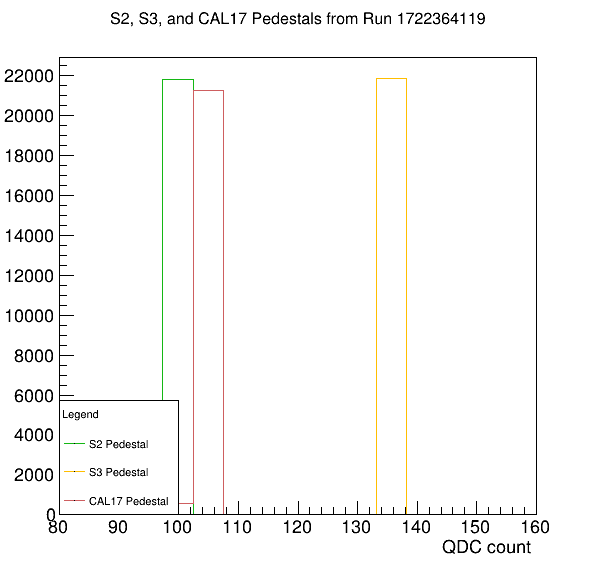

In [8]:
stack0 = ROOT.THStack("stack0", "S2, S3, and CAL17 Pedestals from Run 1722364119")

s2_pedestal_hist.SetLineColor(210)
s2_pedestal_hist.SetTitle("S2 Pedestal")
stack0.Add(s2_pedestal_hist)


s3_pedestal_hist.SetLineColor(92)
s3_pedestal_hist.SetTitle("S3 Pedestal")
stack0.Add(s3_pedestal_hist)

cal17_pedestal_hist.SetLineColor(46)
cal17_pedestal_hist.SetTitle("CAL17")
stack0.Add(cal17_pedestal_hist)

c0 = ROOT.TCanvas("c0", "S2, S3, and CAL17 Pedestals from Run 1722364119", 10, 10, 600, 600)
c0.cd(1)

stack0.Draw("nostack")
stack0.GetXaxis().SetTitle("QDC count")
stack0.GetYaxis().SetTitle("#Occurances")
stack0.GetXaxis().SetLimits(80, 160)

leg = ROOT.TLegend(0.1, 0.1, 0.3, 0.3, "Legend")
leg.AddEntry(s2_pedestal_hist, "S2 Pedestal")
leg.AddEntry(s3_pedestal_hist, "S3 Pedestal")
leg.AddEntry(cal17_pedestal_hist, "CAL17 Pedestal")
leg.Draw()

c0.Update()

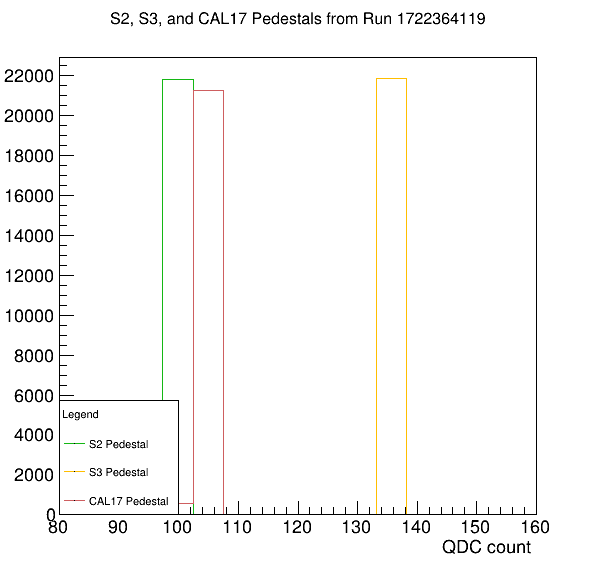

In [9]:
c0.Draw()

Well, that looks quite constant (at least not Gaussian distributed, which is good, there should not be a lot of noise). Let's get the Pedestal mean and standard deviation values for each channel:

In [10]:
print(f"Pedestal S2   : Mean = {s2_pedestal_hist.GetMean():4.1f}, StdDev = {s2_pedestal_hist.GetStdDev():4.1f}")
print(f"Pedestal S3   : Mean = {s3_pedestal_hist.GetMean():4.1f}, StdDev = {s3_pedestal_hist.GetStdDev():4.1f}")
print(f"Pedestal CAL17: Mean = {cal17_pedestal_hist.GetMean():4.1f}, StdDev = {cal17_pedestal_hist.GetStdDev():4.1f}")

Pedestal S2   : Mean = 98.5, StdDev =  0.5
Pedestal S3   : Mean = 135.6, StdDev =  0.5
Pedestal CAL17: Mean = 103.1, StdDev =  0.4


A couple of observations:
1) we could have done this without histograms, we could for example have found the mean, average, standard deviation, minimum, maximum, 80/20 percentille values, etc. while looping over all the entries in the list. Just because there is a histogram class available does not mean that we have to use it :-)

2) The values for the different channels are different - the QDC generates the pedestal internally but it does not manage to create exactly the same current for each channel. This means, we have to keep track of the pedestal values per channel!

3) The standard deviation is quite small compared to the mean values, so taking the mean values of each pedestal as the "measured" contribution to the QDC count is a good approximation. 

The pedestal current $I_{PED}$ is added to all signals during the integration. Therfore, every result should have at least the charge measured for the pedestal as result. In order to get the "real" contribution for each channel, we have to **compensate** for the pedestal. This is done by subtracting the pedestal value from the measured QDC count for each entry:

In [11]:
# The QDC can only count in integer values. Therfore, values like "98.5" or "135.6" do not make a lot of sense.
# To be on the safe side and to account for the finite standard deviation, we take the first integer number that is smaller than the 
# calculated mean value for the pedestal:

pedestals = {
    "QDC0_ch0": 98, 
    "QDC0_ch1": 135,
    "QDC0_ch2": 103,
}

In [12]:
num_bins = 800

histograms_with_pedestal = {
    "QDC0_ch0": ROOT.TH1I("s2", "S2", num_bins, 0, 4096), 
    "QDC0_ch1": ROOT.TH1I("s3", "S3", num_bins, 0, 4096),
    "QDC0_ch2": ROOT.TH1I("cal17", "CAL17", num_bins, 0, 4096),
}

histograms_with_correction = {
    "QDC0_ch0": ROOT.TH1I("s2_no_pedestal", "S2, without Pedestal", num_bins, 0, 4096), 
    "QDC0_ch1": ROOT.TH1I("s3_no_pedestal", "S3, without Pedestal", num_bins, 0, 4096),
    "QDC0_ch2": ROOT.TH1I("cal17_no_pedestal", "CAL17, without Pedestal", num_bins, 0, 4096),
}

Let's apply this to the example we used last week:

In [13]:
path_no_abs = path_to_data_files / Path("1722178299.root")
raw_no_absorber = ROOT.TFile(str(path_no_abs.absolute()))

In [23]:
# Get the total number of events in the root file:
print(f"Total number of events in this file: {tree.GetEntries()}")

NameError: name 'tree' is not defined

In [24]:
tree = raw_no_absorber.Get("RAWdata")

for entry in tree:
    for channel, pedestal_value in pedestals.items():
        val = int(getattr(entry, channel))
        histograms_with_pedestal[channel].Fill(val)
        
        corrected_val = max(val - pedestal_value, 0)
        histograms_with_correction[channel].Fill(corrected_val)
        

In [25]:
stack_s2 = ROOT.THStack("stack_s2", "Comparison S2 with and without pedestal contribution from Run 1722178299")

histograms_with_pedestal["QDC0_ch0"].SetLineColor(210)
histograms_with_pedestal["QDC0_ch0"].SetTitle("S2 With Pedestal")
stack_s2.Add(histograms_with_pedestal["QDC0_ch0"])

histograms_with_correction["QDC0_ch0"].SetLineColor(2)
histograms_with_correction["QDC0_ch0"].SetTitle("S2 With Correction")
stack_s2.Add(histograms_with_correction["QDC0_ch0"])

In [26]:
c1 = ROOT.TCanvas("c1", "Comparison S2 with and without pedestal contribution from Run 1722178299", 10, 10, 600, 600)
c1.cd(1)

stack_s2.Draw("nostack")
stack_s2.GetXaxis().SetTitle("QDC count")
stack_s2.GetYaxis().SetTitle("#Occurances")
stack_s2.GetXaxis().SetLimits(0, 1500)

leg = ROOT.TLegend(0.6, 0.6, 0.8, 0.8, "Legend")
leg.AddEntry(histograms_with_pedestal["QDC0_ch0"], "S2 with pedestal")
leg.AddEntry(histograms_with_correction["QDC0_ch0"], "S2 without pedestal")
leg.Draw()

c1.Update()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


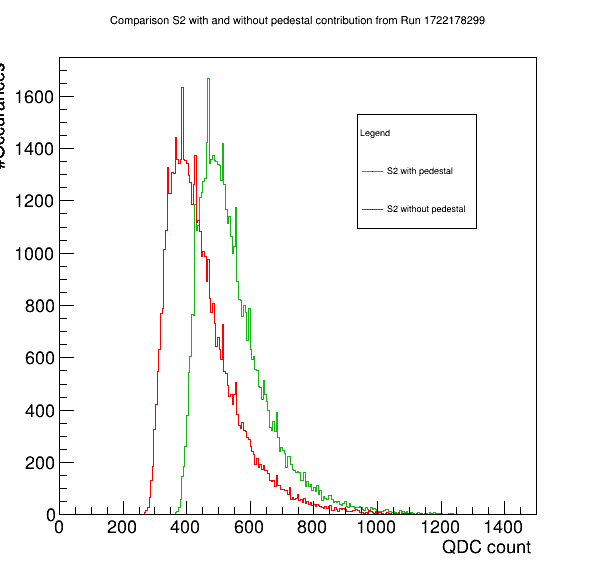

In [27]:
c1.Draw()

**NOTE**: 
The shape of the distribution should not change, but the curve is displaced horizontally (and the binning into the histogram will be slightly different - it is possible that the shape of the curve appears to change slightly)

## Using TDC and Scaler Data To Filter Events

Let's look into the other two digitizer modules that we have mostly ignored until now:

![](https://codimd.web.cern.ch/uploads/upload_ffa71d34fb90f58272cd6eb58a24ba53.png)

Looking at the signal table, there are two TDCs: 
- TDC1 contains all the signals from the DWCs (L, R, U, D + coincidences of the anode signals) plus some convenient signals that could be useful for data analysis with the DWC (S0 & S1, S2 & S3, FS0 & FS1)
- TDC0 contains signals from the cherenkov detectors, from the scintillators and from the calorimeter

Both TDCs and Scalers take **digital** signals (compare this to the QDC which takes **analog** signals)
>

The main difference between the TDCs and the Scaler are
- TDCs record per-particle information (i.e., the arrival time of a signal relative to the trigger)
- Scalers count every arriving signal, even between trigger pulses. As such, the scaler is closer to the idea behind CESAR than the other things we do with TDAQ
- If we readout the channels of the scaler whenever we have a trigger, then we get a "snapshot" of the counting values for each channel for each event

Since the scaler is not affected by the busy logic (see the previous exercise), it can in theory record contributions from every particle that arrives. It also counts noise (unless we count coincidence signals). 

Useful things to do with a scaler:
- You can calculate the ratio of how many particles have hit your detector compared to how many particles you could record with TDAQ#
- You can check if the number of particles below/above the threshold of the XCETs recorded by TDAQ is representative of the ensemble of all arriving particles or if we had some "bias" in selecting them
- You can check if the beam composition (or momentum distribution) remains stable over time or if there are fluctuations
- You can check the signal/noise ratio for uncoincided signals
- Debugging (how do you "see" signals if for example the trigger has an issue and you do not record data?)
- You can make our colleague Jorgen very happy (he is a huge fan of the scaler)

In the following, we will mostly look into the TDC data since it is particle by particle. But you can think about what information might be useful to have via the scaler (hint, data rate, hint!)

### Read TDC Data

Lets continue with the data file for run `1722178299` and let's see which branches are available for a TDC channel.

In [28]:
# Uncomment and run the following line if you want to get a listing of all branches in the tree:
# tree.Print()

TDC0 ch0 contains the signal `XCET040 & S0 & S1`. Whenever a particle was above the threshold of the high pressure cherenkov, you should get a hit on this channel. There are different branches for different aspects of this signal:

``` 
*............................................................................*
*Br  128 :NTDC0_ch0 : UInt_t Number of entries in branch TDC0_ch0            *
*Entries :    56630 : Total  Size=     227710 bytes  File Size  =      19598 *
*Baskets :        8 : Basket Size=      32000 bytes  Compression=  11.59     *
*............................................................................*
*Br  129 :TDC0_ch0  : TDC0_ch0[NTDC0_ch0]/i                                  *
*Entries :    56630 : Total  Size=     420715 bytes  File Size  =     180818 *
*Baskets :       21 : Basket Size=      32000 bytes  Compression=   2.32     *
*............................................................................*
*Br  130 :NTDC0_ch0_leading :                                                *
*         | UInt_t Number of entries in branch TDC0_ch0_leading              *
*Entries :    56630 : Total  Size=     227806 bytes  File Size  =      19656 *
*Baskets :        8 : Basket Size=      32000 bytes  Compression=  11.56     *
*............................................................................*
*Br  131 :TDC0_ch0_leading : TDC0_ch0_leading[NTDC0_ch0_leading]/i           *
*Entries :    56630 : Total  Size=     420947 bytes  File Size  =     180981 *
*Baskets :       21 : Basket Size=      32000 bytes  Compression=   2.32     *
*............................................................................*
*Br  132 :NTDC0_ch0_trailing :                                               *
*         | UInt_t Number of entries in branch TDC0_ch0_trailing             *
*Entries :    56630 : Total  Size=     227818 bytes  File Size  =       1954 *
*Baskets :        8 : Basket Size=      32000 bytes  Compression= 116.29     *
*............................................................................*
*Br  133 :TDC0_ch0_trailing : TDC0_ch0_trailing[NTDC0_ch0_trailing]/i        *
*Entries :    56630 : Total  Size=     228794 bytes  File Size  =       3010 *
*Baskets :       15 : Basket Size=      32000 bytes  Compression=  75.73     *
```

- `NTDC0_ch0xyz` gives the **number of hits for each event** on `ch0`
- `TDC0_ch0xyz` gives the **times measured for all the hits belonging to each event** on `ch0`

The signals are grouped by `leading`, `trailing` or no edge. These belong to different modes for the TDC.

**We usually use only leading edge**

The `CAEN V1290N` is a multi-hit TDC. this means, that for each event / entry, we get a vector of time measurements. This is even the case if there is only a single hit (which should happen most of the time). The `NTDC0` branch contains how many hits you received.

In [29]:
for entry in tree:
    tdc_measurements = [x for x in entry.TDC0_ch0_leading]
    num_hits = entry.NTDC0_ch0_leading
    # Only do a single event
    break
    
print(f"TDC0 measurement: {tdc_measurements}")
print(f"number of hits  : {num_hits} -> this should be identical to taking the length of the measurement vector: {len(tdc_measurements)}")

TDC0 measurement: [6544]
number of hits  : 1 -> this should be identical to taking the length of the measurement vector: 1


Let's continue until we get more than one hit:

In [30]:
for event_id, entry in enumerate(tree):
    num_hits = entry.NTDC0_ch0_leading
    if num_hits <= 1:
        continue
    tdc_measurements = [x for x in entry.TDC0_ch0_leading]
    # Only do a single event
    break
    
print(f"Event ID: {event_id}")
print(f"TDC0 measurement: {tdc_measurements}")
print(f"number of hits  : {num_hits} -> this should be identical to taking the length of the measurement vector: {len(tdc_measurements)}")

Event ID: 194
TDC0 measurement: [7355, 21129]
number of hits  : 2 -> this should be identical to taking the length of the measurement vector: 2


TDC measurements are expressed as counting values - that's why the histograms are also integer valued!

Each count corresponds to one tick of the TDC which has a length of `25 ps`. You can calculate the time since the reference time (which is calculated relative to the trigger) by multiplying the value with 25 ps!

It is possible to have no entries in the vector - then the `NTDC0_ch0_leading` histogram has a 0. For the Cherenkov detector, this means that no particle could produce enough photons to be registered (so the particle was most likely under the threshold)

In [31]:
for event_id, entry in enumerate(tree):
    num_hits = entry.NTDC0_ch0_leading
    if num_hits > 0:
        continue
    tdc_measurements = [x for x in entry.TDC0_ch0_leading]
    # Only do a single event
    break
    
print(f"Event ID: {event_id}")
print(f"TDC0 measurement: {tdc_measurements}")
print(f"number of hits  : {num_hits} -> this should be identical to taking the length of the measurement vector: {len(tdc_measurements)}")

Event ID: 5
TDC0 measurement: []
number of hits  : 0 -> this should be identical to taking the length of the measurement vector: 0


**IDEA**: If we only want to figure out **if** a particle had a count, we do not have to read the values from the vector. We can, but usually we do not have to. 